In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0,'/home/gaspar/git/pyhacores/under_construction/fft/')
from fft_core import R2SDF
from pyha import Hardware, simulate, sims_close, Complex, resize
import pandas as pd


In [3]:
from spectrogram import Spectrogram
from pathlib import Path
from data import load_iq

fft_points = 256
dut = Spectrogram(nfft=fft_points)


inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
from scipy import signal
inp = signal.decimate(inp, 8)
print(len(inp))
print(inp.max())
inp *= 0.25

6736
(0.8510165947291936-0.13510283540276277j)


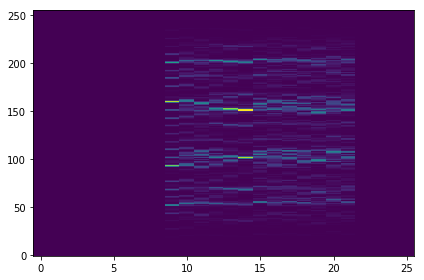

In [4]:
_, _, out = signal.spectrogram(inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

out = np.roll(out, fft_points//2, axis=0)
plt.imshow(out, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

In [5]:
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


AttributeError: 'Complex' object has no attribute 'conjugate'

In [ ]:
plt.imshow(sims['MODEL'], interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

In [ ]:
np.array(sims['PYHA']).shape

In [ ]:
plt.plot(sims['PYHA'])
plt.show()

In [ ]:
plt.plot(sims['MODEL'])
plt.show()

In [ ]:
np.array(sims['MODEL']).shape

In [ ]:
x = sims['PYHA']
x = np.array(x[:int(len(x) // 256) * 256])
chunks = np.split(x, len(x) // 256)
plt.imshow(chunks, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

In [ ]:
fft_size = 1024
dut = R2SDF(fft_size)
inp = np.random.uniform(-1, 1, fft_size) + np.random.uniform(-1, 1, fft_size) * 1j
inp *= 0.25

sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])

sims['PYHA'] = np.array(sims['PYHA']) * fft_size
sims = pd.DataFrame(sims)


In [ ]:
sims['PYHA'] = np.array(sims['PYHA']) / 2
err = sims['MODEL'] - sims['PYHA']
sig_pow = np.sum(np.abs(sims['MODEL']))
err_pow = np.sum(np.abs(err))

plt.plot(20*np.log10(np.abs(sims['MODEL'])))
plt.plot(20*np.log10(np.abs(sims['PYHA'])))
plt.show()

plt.plot(20*np.log10(np.abs(err)))
plt.show()

print(20*np.log10(sig_pow/err_pow))

# Old Radix 2 stuff

In [ ]:
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def correct_radix2_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def W(k, N):
    return np.exp(-1j*(2*np.pi/N)*k)


def radix2_fft_recursive(s):
    N = len(s)
    x = [0] * N
    half = N//2
    for i in range(half):
        x[i] = s[i] + s[i+half]
        x[i+half] = (s[i] - s[i+half]) * W(i, N)
        print(N, s[i], s[i+half])
    
    if len(x) > 2:
        first = radix2_fft_recursive(x[:half])
        second = radix2_fft_recursive(x[half:])
        
        return first + second
    return x

def radix2_fft(s):
    r = radix2_fft_recursive(s)
#     r = np.array(r)[correct_radix2_indexes(len(x))]
    return r

In [ ]:
x = (np.random.uniform(-1, 1, 4) + np.random.uniform(-1, 1, 4)*1j) * 0.5
x = [0, 1, 2, 3]
model = fft(x)

ind = correct_radix2_indexes(16)
print(ind)
x = np.array(x)[ind]

dut = radix2_fft(x)
print(dut)
print(model)
np.testing.assert_allclose(model, dut)

In [ ]:
x = [0.1 + 0.2j, 0.3 + 0.4j]
fft(x)

In [ ]:
x[0] + x[1]

In [ ]:
N = 2
k = 0
n = 1
np.exp( (-2j*np.pi*k*n) /N)

In [ ]:
N = 8
r = np.empty(shape=(N,N))
for k in range(N):
    for n in range(N):
        r[k][n] = np.exp(-1j * 2 * np.pi * k * n / N)
        

In [ ]:
pd.DataFrame(r)

In [ ]:
def W(k, N):
    return np.exp(-1j*(2*np.pi/N)*k)

def radix2_fft_hardcode(s, N=8):
    # stage 1
    
    x0 = s[0] + s[4]
    x4 = (s[0] - s[4]) * W(0, N)
    
    x1 = s[1] + s[5]
    x5 = (s[1] - s[5]) * W(1, N)
    
    x2 = s[2] + s[6]
    x6 = (s[2] - s[6]) * W(2, N)
    
    x3 = s[3] + s[7]
    x7 = (s[3] - s[7]) * W(3, N)
    print(x0, x1, x2, x3, x4, x5, x6, x7)
    
    
    # stage 2.1
    x00 = x0 + x2
    x02 = (x0 - x2) * W(0, N/2)
    
    x01 = x1 + x3
    x03 = (x1 - x3) * W(1, N/2)
    
    # stage 2.2
    x10 = x4 + x6
    x12 = (x4 - x6) * W(0, N/2)
    
    x11 = x5 + x7
    x13 = (x5 - x7) * W(1, N/2)
    
    
    # state 3.1
    x000 = x00 + x01
    x001 = (x00 - x01) * W(0, N/2/2)
    
    # stage 3.2
    x002 = x02 + x03
    x003 = (x02 - x03) * W(0, N/2/2)
    
    # state 3.3
    x004 = x10 + x11
    x005 = (x10 - x11) * W(0, N/2/2)
    
    # state 3.4
    x006 = x12 + x13
    x007 = (x12 - x13) * W(0, N/2/2)
    
    return [x000, x004, x002, x006, x001, x005, x003, x007]



In [ ]:
for i, o in enumerate(radix2_fft_hardcode(x)):
    print(i, o)

In [ ]:
my_fft(x)

In [ ]:
x = np.random.uniform(-1, 1, 1024)

In [ ]:
np.exp(-2*np.pi*1j*1024*2*2*2*2*2)

In [ ]:
N = 8
t = np.arange(N) / N 
c = np.exp(-2*np.pi*1j*1*t)
print(c)

In [ ]:
def my_fft(x, N=None):
    if N is None:
        N = len(x)
    out = []
    t = np.arange(N) / N
    for i in range(N):
#         np.exp(-2*np.pi*1j*i*t)
        binn = np.sum(x * W(i, N))
        out.append(binn)
    return out

In [ ]:
np.sum(x * c)

In [ ]:
plt.plot(c.real)
plt.plot(c.imag)
plt.show()